## Introduction and Environment

Before we build any models, we’ll set up a small, reproducible PyTorch environment.  
Our playground dataset will be **Fashion-MNIST** – a drop-in replacement for the classic handwritten-digits MNIST, created by Zalando as a “slightly harder, more realistic MNIST.” It has the *same* shape and splits (60k train / 10k test of 28×28 grayscale images) but the pixels now show clothes: **10 categories** such as T-shirt/top, Trouser, Sneaker, Bag, and Ankle boot. That means all the classic MNIST code still works, but the problem is closer to real image classification and less likely to be “solved by accident” with toy models.

On top of that we’ll use a **Tiny VGG-style CNN**: a slimmed-down version of the famous VGG network from 2014, which showed that simply stacking many small 3×3 convolutions (`Conv → ReLU → Conv → ReLU → MaxPool`) can reach state-of-the-art performance on ImageNet. Full VGG has hundreds of millions of parameters and is far too heavy for 28×28 images, but a **TinyVGG** keeps the same idea in a compact form that trains quickly on CPU or a single GPU. In this section we’ll import PyTorch, TorchVision, NumPy, Matplotlib, and print the library versions so runs are reproducible and it’s clear which software stack we’re using.


In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

print(torch.__version__)
print(torchvision.__version__)


2.9.1+cu126
0.24.1+cu126


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device={device}")

device=cuda


## 1. Getting and understanding the dataset

This step will involve:
* loading / downloading the data
* basic inspections (shapes, dtypes, ranges)
* light EDA: class distribution, a few sample plots, etc.


### 1.1 – Define transforms and load the raw dataset

In this step I do two things:

1. **Define the image transforms** I’ll use later:
   - `train_transform` applies:
     - `ToImage` to treat the raw tensor as an image.
     - `ToDtype(..., scale=True)` to convert pixels from `uint8` \[0, 255\] to `float32` \[0.0, 1.0\].
     - a small random horizontal flip for data augmentation.
     - a final `Normalize(mean=[0.5], std=[0.5])` so the grayscale values are roughly in \[-1, 1\].
   - `test_transform` uses the **same preprocessing** (`ToImage` → `ToDtype` → `Normalize`) but **no randomness**, so evaluation is deterministic.

2. **Download and load the raw FashionMNIST splits** with `torchvision.datasets.FashionMNIST`.  
   At this point I still request the data with `transform=None`, so the `FashionMNIST` objects simply give me the original images and labels via `.data` and `.targets`. The actual preprocessing and augmentation is handled later by my custom `FMNISTDataset`, which applies `train_transform` or `test_transform` in its `__getitem__` method.

Wrapping the `FashionMNIST` calls in `try/except` blocks lets me surface clear error messages if the download or loading fails.


#### 1.1.1 Define the image transforms

1. **`ToImage`**

   - **What it does**
     - Tells `torchvision` to treat the raw tensor as an image in **(C × H × W)** format.
     - For FashionMNIST, which is stored as 2D tensors (H × W), it adds the missing channel so grayscale becomes C = 1.
   - **Intuition**
     - The raw data is “just an array of numbers”.
     - `ToImage` marks it as an image and fixes the shape so later image transforms (Affine, Blur, Flips, etc.) know how to operate on it.
   - **Why**
     - Many geometric and photometric transforms expect this image layout.
     - It’s basically a **format/shape fix** to make everything downstream work correctly.

2. **`ToDtype(torch.float32, scale=True)`**

   - **What it does**
     - Converts the image from `uint8` to `float32`.
     - Because `scale=True`, it divides by 255, mapping pixel values from `[0, 255]` → `[0.0, 1.0]`.
   - **Intuition**
     - Neural nets like continuous values, not bytes.
     - Working in `[0, 1]` is a standard convention and plays nicely with normalization.
   - **Why**
     - Training is more stable with float inputs in a well-defined range.
     - This step is basically **“make it a float image in `[0, 1]`”**.

3. **`RandomMultiply` (brightness augmentation)**

   - **What it does**
     - Samples a random factor `factor ~ Uniform(min_factor, max_factor)`.
     - Applies: `img' = clamp(img * factor, 0, 1)`.
   - **Intuition**
     - `factor < 1` → the whole image gets darker.
     - `factor > 1` → the whole image gets brighter.
     - Every pixel is multiplied by the same factor, so relative differences are preserved.
   - **Why**
     - Real-world camera exposure and lighting vary a lot.
     - Training on brighter and darker versions helps the model **generalize to different lighting conditions**.

4. **`RandomLinearContrast` (contrast around 0.5)**

   - **What it does**
     - Samples `α ~ Uniform(min_alpha, max_alpha)`.
     - Adjusts contrast around a midpoint (here ~0.5):  
       `img' = clamp(midpoint + α * (img − midpoint), 0, 1)`.
   - **Intuition**
     - `α = 1` → no change.
     - `α > 1` → high contrast: dark regions get darker, bright regions get brighter.
     - `α < 1` → low contrast: everything moves closer to mid-gray.
     - **Brightness vs contrast**
       - Brightness = **add** a constant (shift everything up or down).
       - Contrast = **stretch/compress** differences around a midpoint.
   - **Why**
     - Real images can be washed out (low contrast) or very punchy (high contrast).
     - Varying contrast during training makes the model more robust to these appearance changes.

5. **`GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))`**

   - **What it does**
     - Convolves the image with a Gaussian kernel.
     - Each pixel is replaced by a weighted average of its neighbors; closer neighbors get higher weight (Gaussian / bell curve).
   - **Intuition**
     - **Sharp image** → big differences between neighboring pixels.
     - **Blurred image** → neighboring pixels are more similar; edges are softened.
     - `σ` (sigma) controls how strong the blur is:
       - small σ → slight soften
       - large σ → very smudged
   - **Why**
     - Real images can be slightly out of focus or blurred due to motion.
     - Training with occasional blur makes the model **more tolerant of mild blur in test images**.
     - In this setup:
       - `kernel_size = 3` → small 3×3 neighborhood.
       - `sigma = (0.1, 1.0)` → σ is randomly sampled in this range per image.

6. **`RandomHorizontalFlip(p=0.3)`**

   - **What it does**
     - With probability `p`, flips the image left ↔ right.
   - **Intuition**
     - With `p = 0.3`, about 30% of images are mirrored horizontally.
     - For many tasks, left/right orientation doesn’t change the class (e.g., a shoe is still a shoe).
   - **Why**
     - Teaches the model that **horizontal orientation is not essential**.
     - Improves generalization to mirrored or slightly different viewpoints.

7. **`RandomVerticalFlip(p=0.3)`**

   - **What it does**
     - With probability `p`, flips the image top ↔ bottom.
   - **Intuition**
     - Similar to `RandomHorizontalFlip`, but around the horizontal axis.
     - For FashionMNIST this is a strong augmentation (e.g., upside-down shoes), but can still encourage robustness.
   - **Why**
     - Forces the model to rely more on local patterns and shape, not just an assumed “upright” orientation.
     - Should be used with care on datasets where vertical orientation carries semantic meaning.

8. **`RandomAffine`**

   - **What it does**
     - Applies a random affine transformation that can include:
       - small **rotations**
       - **translations** (shifts)
       - **scaling** (zoom in/out)
       - **shear**
   - **Your parameters**
     - `degrees = (-10, 10)` → rotate randomly between −10° and +10°.
     - `translate = (0.05, 0.05)` → shift up to ±5% of image size in x and y.
     - `scale = (0.9, 1.1)` → zoom between 90% and 110%.
     - `shear = (-5, 5)` → small shear in degrees.
   - **Intuition**
     - Real objects rarely appear perfectly centered, upright, and identically scaled.
     - Affine transforms simulate **small camera viewpoint changes and misalignments**.
   - **Why**
     - Makes the model more invariant (or at least tolerant) to small rotations, shifts, and scale changes.
     - Reduces overfitting to a very specific pose or alignment.

9. **`Normalize(mean=[0.5], std=[0.5])`**

   - **What it does**
     - Normalizes each channel using:  
       `img_norm = (img − mean) / std`
   - **Intuition**
     - Input after `ToDtype(..., scale=True)` is in `[0, 1]`.
     - Using `mean = 0.5`, `std = 0.5` maps values roughly into `[-1, 1]`.
     - This centers pixel values around zero and scales them to a similar range.
   - **Why**
     - Many neural net layers (especially with ReLUs) train better when inputs are **approximately zero-mean with unit-ish variance**.
     - Normalization is standard practice in computer vision and matches what many pretrained models expect.

10. **Overall transform pipeline (big picture)**

    - **Stage 1 – Format & scale**
      - `ToImage` → `ToDtype(..., scale=True)`
      - Result: a proper image tensor in `(C, H, W)` with values in `[0, 1]`.
    - **Stage 2 – Photometric augmentation (appearance)**
      - `RandomMultiply` (brightness)
      - `RandomLinearContrast`
      - `GaussianBlur`
      - Result: varied lighting, contrast, and sharpness conditions.
    - **Stage 3 – Geometric augmentation (shape/position)**
      - `RandomHorizontalFlip`
      - `RandomVerticalFlip`
      - `RandomAffine`
      - Result: varied poses, positions, and slight geometric distortions.
    - **Stage 4 – Final normalization for the network**
      - `Normalize(mean=[0.5], std=[0.5])`
      - Result: inputs centered around 0 and scaled to a stable range.
    - **Net effect**
      - The model sees many realistic variations of the same digit/clothing item.
      - At the same time, every image ends up in a **consistent, normalized format** that the network can learn from efficiently.


In [ ]:
import torchvision.transforms.v2 as v2
import torch


# Assumes input coming into these Lambdas is a float tensor in [0, 1] (which you get from ToDtype(..., scale=True)).
# Random Multiply (brightness)
def RandomMultiply(min_factor=0.5, max_factor=1.5):
    def _op(img: torch.Tensor):
        # print("in RandomMultiply")
        # sample a random factor in [min_factor, max_factor]
        factor = torch.empty(1).uniform_(min_factor, max_factor).item()
        # or factor = torch.rand(1).mul(max_factor - min_factor).add(min_factor).item()
        
        # scale brightness and clamp to [0, 1]
        return (img * factor).clamp(0.0, 1.0)
    
    return v2.Lambda(_op)

# Random LinearContrast (contrast around 0.5)
def RandomLinearContrast(min_alpha=0.5, max_alpha=1.5, midpoint=0.5):
    def _op(img: torch.Tensor):
        # print("in RandomLinearContrast")
        alpha = torch.rand(1).mul(max_alpha - min_alpha).add(min_alpha).item()
        # or alpha = torch.empty(1).uniform_(min_alpha, max_alpha).item()
        
        # x' = (midpoint + alpha * (x - midpoint))
        return (midpoint + alpha * (img - midpoint)).clamp(0.0, 1.0)
    
    return v2.Lambda(_op)

## RandomPixelDropout
# Randomly sets each pixel to 0 with probability p.
# Assumes img is a float tensor in [0, 1], shape (C, H, W).
def RandomPixelDropout(p: float = 0.2):
    def _op(img: torch.Tensor):
        # print("in RandomPixelDropout")
        # mask ~ Bernoulli(1-p): 1 = keep, 0 = drop
        keep_mask = torch.rand_like(img).gt(p).float()
        return img * keep_mask
    return v2.Lambda(_op)

# With probability p per pixel, replace with salt (1.0) or pepper (0.0).
# Assumes img is a float tensor in [0, 1], shape (C, H, W).
def RandomSaltAndPepperNoise(p: float = 0.2):
    def _op(img: torch.Tensor):
        # print("in RandomSaltAndPepperNoise")
        noise_mask = torch.rand_like(img).lt(p) # True where we add noise, False elsewhere 
        
        salt_mask = torch.rand_like(img).lt(0.5)
        salt_vals = torch.ones_like(img)
        pepper_vals = torch.zeros_like(img)
        
        # For each element, if salt_mask is True, take the value from salt_vals, otherwise take it from pepper_vals.
        noise_vals = torch.where(salt_mask, salt_vals, pepper_vals)

        # For each element, if noise_mask is True, take the value from noisy_vals, otherwise take it from img
        return torch.where(noise_mask, noise_vals, img)
    return v2.Lambda(_op)
    
  
train_transform = v2.Compose([
    # --- Format & scale ---
    # Make sure the raw tensor is treated as an image (C x H x W).
    # For FashionMNIST (H x W), this will add a channel dimension.
    v2.ToImage(),

    # Convert to float32 and scale from [0, 255] → [0.0, 1.0]
    v2.ToDtype(torch.float32, scale=True),
    
    # --- Photometric augments (fixed order is fine) ---
    v2.RandomApply([RandomMultiply(0.5, 1.5)], p=0.1),
    v2.RandomApply([RandomLinearContrast(0.5, 1.5)], p=0.1),
    
    # --- Group of ops whose ORDER can be random ---
    v2.RandomOrder([
        # Gaussian blur: kernel 3x3, sigma sampled uniformly in [0.1, 1.0]
        v2.RandomApply([v2.GaussianBlur(kernel_size=3, sigma=(0.1, 0.3))], p=0.1),
        
        # noise augmentations (pick one or both, with reasonable p)
        v2.RandomApply([RandomPixelDropout(p=0.05)], p=0.1),
        v2.RandomApply([RandomSaltAndPepperNoise(p=0.05)], p=0.1)
    ]),
    
    # --- Geometric augments ---
    # Small augmentation: horizontally flip with probability 0.5
    v2.RandomApply([v2.RandomHorizontalFlip(p=0.2)],p=0.5),
      
    # Vertical flip with probability 0.3
    v2.RandomApply([v2.RandomVerticalFlip(p=0.2)],p=0.5),
    
    # Geometric augmentation: random affine transform
    #    - small rotations, translations, zoom, and shear.
    v2.RandomApply([v2.RandomAffine(
        degrees=(-10, 10),        # random rotation between -10° and +10°
        translate=(0.05, 0.05),   # up to ±5% shift in both x and y
        scale=(0.9, 1.1),         # zoom between 90% and 110%
        shear=(-5, 5))],            # small shear in degrees
        p=0.3),
    
    # --- Final normalization ---
    # Normalize grayscale channel: (x - 0.5) / 0.5
    # This centers data around 0 and gives roughly [-1, 1] range.
    v2.Normalize(mean=[0.5], std=[0.5]),
])

# ----------------------------------------------------------
# Test transform: ONLY preprocessing (no randomness)
# ----------------------------------------------------------
test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5], std=[0.5]),
])


#### 1.1.2 Download and load the raw FashionMNIST splits

Next, I download the raw FashionMNIST train/test splits (with `transform=None`); the `train_transform` and `test_transform` defined above will be applied later via my custom `FMNISTDataset`.


In [4]:
# Setup Training data
import textwrap as tw

# -- These dataloaders are used only to download and get the images and labels -- 
try:
    fmnist_train = datasets.FashionMNIST(
        root="/home/onkar/Good/modern-cv-with-pytorch/data",
        train=True,
        download=True,
        transform=None, # <- raw data, transform done later
        target_transform=None,
    )
except RuntimeError as e:
    print(f"Error loading training dataset: {tw.fill(str(e), width=80)}")

try:
    fmnist_test = datasets.FashionMNIST(
        root="/home/onkar/Good/modern-cv-with-pytorch/data",
        train=False,
        download=True,
        transform=test_transform,
        target_transform=None
    )
except RuntimeError as e:
    print(f"Error loading test dataset: {tw.fill(str(e), width=80)}")

### 1.2 – Extract raw tensors and check basic structure

In [5]:
train_images, train_targets = fmnist_train.data, fmnist_train.targets
test_images, test_targets = fmnist_test.data, fmnist_test.targets


# 1. Dataset sizes + image shape
print(f"Training images: {train_images.shape}, Train targets: {train_targets.shape}")
print(f"Training images datatype: {train_images.dtype}, Training targets datatype: {train_targets.dtype}")

print(f"Test images: {test_images.shape}, Test targets : {test_targets.shape}")
print(f"Test images datatype: {test_images.dtype}, Test targets datatype: {test_targets.dtype}")

# 2. Label sanity checks
print(f"Training labels range: {train_targets.min()} -> {train_targets.max()}")
print(f"Test labels range: {test_targets.min()} -> {test_targets.max()}")

# 3. Basic pixel stats (on raw tensors)
print(f"Train pixel min/max: {train_images.min()} -> {train_images.max()}")
print(f"Test images min/max: {test_images.min()} -> {test_images.max()}")
print(f"Train pixel mean/std: {train_images.float().mean():.3f}, {train_images.float().std():.3f}")

# 4. Rough memory footprint
train_mem = train_images.itemsize * train_images.nbytes
print(f"Total memory required for training data: {train_mem/(1024 ** 2):.3f} MB")
test_mem = test_images.itemsize * test_images.nbytes
print(f"Total memory required for test data: {test_mem/(1024 ** 2):.3f} MB")


Training images: torch.Size([60000, 28, 28]), Train targets: torch.Size([60000])
Training images datatype: torch.uint8, Training targets datatype: torch.int64
Test images: torch.Size([10000, 28, 28]), Test targets : torch.Size([10000])
Test images datatype: torch.uint8, Test targets datatype: torch.int64
Training labels range: 0 -> 9
Test labels range: 0 -> 9
Train pixel min/max: 0 -> 255
Test images min/max: 0 -> 255
Train pixel mean/std: 72.940, 90.021
Total memory required for training data: 44.861 MB
Total memory required for test data: 7.477 MB


### 1.3 – Wrap tensors in a custom `Dataset`

Now that we have the raw tensors (`train_images`, `train_targets`, …), we wrap them in a custom PyTorch `Dataset`.  

This sits between the raw data and the `DataLoader`:

- **Raw tensors** – the data itself in memory.
- **`Dataset`** – knows how to return the *i-th* `(image, label)` pair.
- **`DataLoader`** – takes a `Dataset` and yields shuffled mini-batches.

Our custom `FMNISTDataset` gives us a clean interface with three required methods:

- `__init__` – store tensors and any preprocessing options  
- `__len__` – return dataset size  
- `__getitem__` – return a single `(image, label)` pair (optionally normalized / reshaped)
```

In [6]:
from torch.utils.data import Dataset

# -- Important distinction ! -- 
# FMNISTDataset is a custom Dataset class (not the dataset per se).
# Dataset is an instance of FMNISTDataset
class FMNISTDataset(Dataset):
    # same order as FashionMNIST
    classes = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
    
    def __init__(self, X, y, transform=None, target_transform=None, flatten=False, device=None):
        # X: images (N, H, W), y: labels (N,)
        self.X = X                     # store images
        self.y = y.long()              # store labels as integer class ids
        self.transform = transform     # optional image transform (e.g. augment, normalize)
        self.target_transform = target_transform  # optional label transform
        self.flatten = flatten         # whether to return 1D vectors instead of images
        self.device = device

    def __len__(self):
        # total number of samples
        return len(self.X)

    def __getitem__(self, idx):
        # fetch a single (image, label) pair
        img = self.X[idx]              # shape: (28, 28)
        label = self.y[idx]            # scalar

        # add channel dimension for PyTorch (C, H, W)
        img = img.unsqueeze(0)         # shape: (1, 28, 28)

        if self.flatten:
            # optional: use flat vector for MLPs
            img = img.flatten()        # shape: (784,)

        if self.transform is not None:
            # apply any user-defined image transforms
            img = self.transform(img)

        if self.target_transform is not None:
            # apply any user-defined label transforms
            label = self.target_transform(label)

        return img, label
    
    # -- collate_fn --
    # * stacks a batch of (img, label) into tensors
    # * applies `transform` to the whole batch of images
    def collate_fn(self, batch):
        # batch is a list of (img, label) from __getitem__
        imgs, labels = zip(*batch) # imgs: tuple of (1, 28, 28), labels = tuple of scalars
        
        # Stack into a single tensor: (B, 1, 28, 28), dtype uint8
        imgs = torch.stack(imgs, dim=0)
        
        # apply transformation on the whole batch 
        if self.transform is not None:
            imgs = self.transform(imgs) # apply on whole batch
        
        # Convert the labels to tensors 
        labels = torch.tensor(labels)
            
        if self.device is not None:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)
            
        return imgs, labels


### 1.4 – Create dataset instances and DataLoaders

At this point the FMNISTDataset class is defined, so we can create concrete dataset objects for the training and test splits:

In [7]:
from sympy import subsets
from torch.utils.data import Dataset, Subset, random_split

TRAIN_SPLIT=0.82

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_total = len(train_images)
n_train = int(TRAIN_SPLIT * n_total)
n_val = n_total - n_train

print(f"n_total={n_total}, n_train={n_train}, n_val={n_val}")

# 1. Make index splits (these are just integer indices)
train_indices, val_indices = random_split(range(n_total), [n_train, n_val],
                                    generator=torch.Generator().manual_seed(42))

# 2. Create TWO base datasets with different transforms
full_ds_for_train = FMNISTDataset(train_images, train_targets, device=device,
                                  transform=train_transform) # heavy augmentations

# only ToImage/ToDtype/Normalize
full_ds_for_val   = FMNISTDataset(train_images, train_targets, device=device,
                                  transform=test_transform) # only ToImage/ToDtype/Normalize

# 3. Wrap them in Subset using the SAME indices
train_data = Subset(full_ds_for_train, train_indices.indices)
val_data   = Subset(full_ds_for_val, val_indices.indices)

# 4. Test data is its own dataset
test_data = FMNISTDataset(test_images, test_targets,
                          transform=test_transform)


print("--- SANITY CHECK ---")
print(
    f"full_ds_for_train.classes: {full_ds_for_train.classes}, "
    f"full_ds_for_val.classes: {full_ds_for_val.classes}"
)
print(
    f"train_data.dataset.classes: {train_data.dataset.classes}, "
    f"val_data.dataset.classes:   {val_data.dataset.classes}"
)
print("train_data.dataset is val_data.dataset:", train_data.dataset is val_data.dataset)
print("id(train_data.dataset.transform):", id(train_data.dataset.transform))
print("id(val_data.dataset.transform):  ", id(val_data.dataset.transform))
print("id(test_transform):              ", id(test_transform))

print(f"Length of training dataset: {len(train_data)}")
print(f"Length of validation dataset: {len(val_data)}")
print(f"Length of test dataset: {len(test_data)}")

n_total=60000, n_train=49200, n_val=10800
--- SANITY CHECK ---
full_ds_for_train.classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], full_ds_for_val.classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_data.dataset.classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], val_data.dataset.classes:   ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_data.dataset is val_data.dataset: False
id(train_data.dataset.transform): 132540182231520
id(val_data.dataset.transform):   132540182231568
id(test_transform):               132540182231568
Length of training dataset: 49200
Length of validation dataset: 10800
Length of test dataset: 10000


`train_data`, `val_data` and `test_data` are now *dataset instances* that know how to return the `i`-th `(image, label)` pair, with all the preprocessing logic (e.g. scaling pixels to `[0, 1]`, adding the channel dimension, optionally flattening, and applying any transforms) encapsulated in `__getitem__`.   

Next, we wrap these datasets in `DataLoader`s:

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

# train_data and val_data come from random_split, 
# so they are Subset objects → you access the underlying dataset as train_data.dataset.
train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=train_data.dataset.collate_fn)

val_loader = DataLoader(val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=False, # usually False for val
                        collate_fn=val_data.dataset.collate_fn)

# test_data is directly an FMNISTDataset instance, not a Subset,
# so it has no .dataset attribute. You call its method directly: test_data.collate_fn
test_loader = DataLoader(test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         collate_fn=test_data.collate_fn)

print(f"Train loader type: {type(train_loader)}")
print(F"Train loader: {len(train_loader)}")
print(f"Validation loader: {len(val_loader)}")
print(f"Test loader: {len(test_loader)}")

print(train_transform)



print("=== Sanity checks ===")
print("train_transform:", train_transform)
print("Train dataset transform:", train_data.dataset.transform)
print("Val dataset transform:", val_data.dataset.transform)
print("Test dataset transform:", test_data.transform)

img0, lbl0 = train_data[0]
print("Single sample dtype:", img0.dtype, "shape:", img0.shape)

batch0 = next(iter(train_loader))
Xb, yb = batch0
print("Batch dtype:", Xb.dtype, "shape:", Xb.shape)


Train loader type: <class 'torch.utils.data.dataloader.DataLoader'>
Train loader: 385
Validation loader: 85
Test loader: 79
Compose(
      ToImage()
      ToDtype(scale=True)
      RandomApply(    Lambda(_op, types=['object']))
      RandomApply(    Lambda(_op, types=['object']))
      RandomOrder(transforms=[RandomApply(    GaussianBlur(kernel_size=(3, 3), sigma=[0.1, 0.3])), RandomApply(    Lambda(_op, types=['object'])), RandomApply(    Lambda(_op, types=['object']))])
      RandomApply(    RandomHorizontalFlip(p=0.2))
      RandomApply(    RandomVerticalFlip(p=0.2))
      RandomApply(    RandomAffine(degrees=[-10.0, 10.0], translate=(0.05, 0.05), scale=(0.9, 1.1), shear=[-5.0, 5.0], interpolation=InterpolationMode.NEAREST, fill=0))
      Normalize(mean=[0.5], std=[0.5], inplace=False)
)
=== Sanity checks ===
train_transform: Compose(
      ToImage()
      ToDtype(scale=True)
      RandomApply(    Lambda(_op, types=['object']))
      RandomApply(    Lambda(_op, types=['object']))
  

The `DataLoader` is responsible for:

* taking a dataset
* sampling indices (optionally shuffling them)
* grouping samples into mini-batches of size `BATCH_SIZE`
* returning batched tensors `(xb, yb)` when we iterate over it

In practice, the training loop will use `train_loader` and  `val_loader`/`test_loader` rather than talking to the dataset directly:

In [9]:

batch0 = next(iter(train_loader))
Xb, yb = batch0
print(f"type(Xb): {Xb.dtype}, type(yb): {yb.dtype}")
print(f"Xb.shape: {Xb.shape}, yb.shape:{yb.shape}")

type(Xb): torch.float32, type(yb): torch.int64
Xb.shape: torch.Size([128, 1, 28, 28]), yb.shape:torch.Size([128])


So: the dataset defines *what a single sample looks like*, and the DataLoader defines *how we get batches of those samples during training*.

### 1.5 – Sample inspection

Before training, it's useful to inspect a single sample **as the model will see it** (i.e. after going through our `FMNISTDataset`).  
This lets us confirm:

- pixel range (`[0, 1]` after scaling)  
- tensor shape (`[1, 28, 28]` → `C, H, W`)  
- that the label index maps to the correct class name  
- that the image visually matches the label


image shape: torch.Size([1, 28, 28])
pixel min/max: -1.0 -> 1.0
label index: 2
class name: Pullover


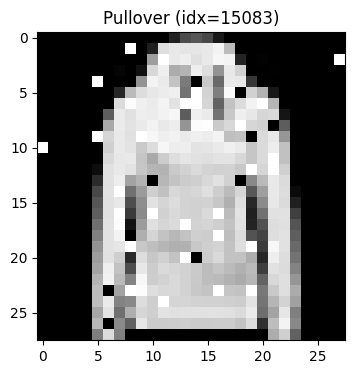

In [10]:
# Check a single item the way the model will see it (after transforms if any):

# Pick up the random sample from the training dataset 
idx = torch.randint(low=0, high=len(train_data), size=(1,)).item()

image, label = train_data[idx]  # this calls FMNISTDataset.__getitem__(idx)

print(f"image shape: {image.shape}")
print(f"pixel min/max: {image.min().item()} -> {image.max().item()}")
print(f"label index: {label.item()}")
print(f"class name: {train_data.dataset.classes[label]}")

# PyTorch - C, H, W
    # Grayscale: (1, H, W) → squeeze → (H, W)
    # Color: (C, H, W) → permute(1, 2, 0) → (H, W, C)
# Numpy/Matplotlib: H, W, C 

plt.figure(figsize=(4, 4))
plt.imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
plt.title(f"{train_data.dataset.classes[label]} (idx={idx})")
plt.show()

### 1.6. Quick visualization grid

To get a feel for the overall dataset, it’s helpful to look at several random samples at once.
Here we draw 16 random indices from `train_data`, fetch each `(image, label)` via our `FMNISTDataset.__getitem__`, and show them in a 4×4 grid with their class names as titles.

This lets us quickly check:

* that different classes really look different
* that images are centered and roughly aligned
* that the labels match what we visually see
* that there’s no obvious corruption or weird artifacts


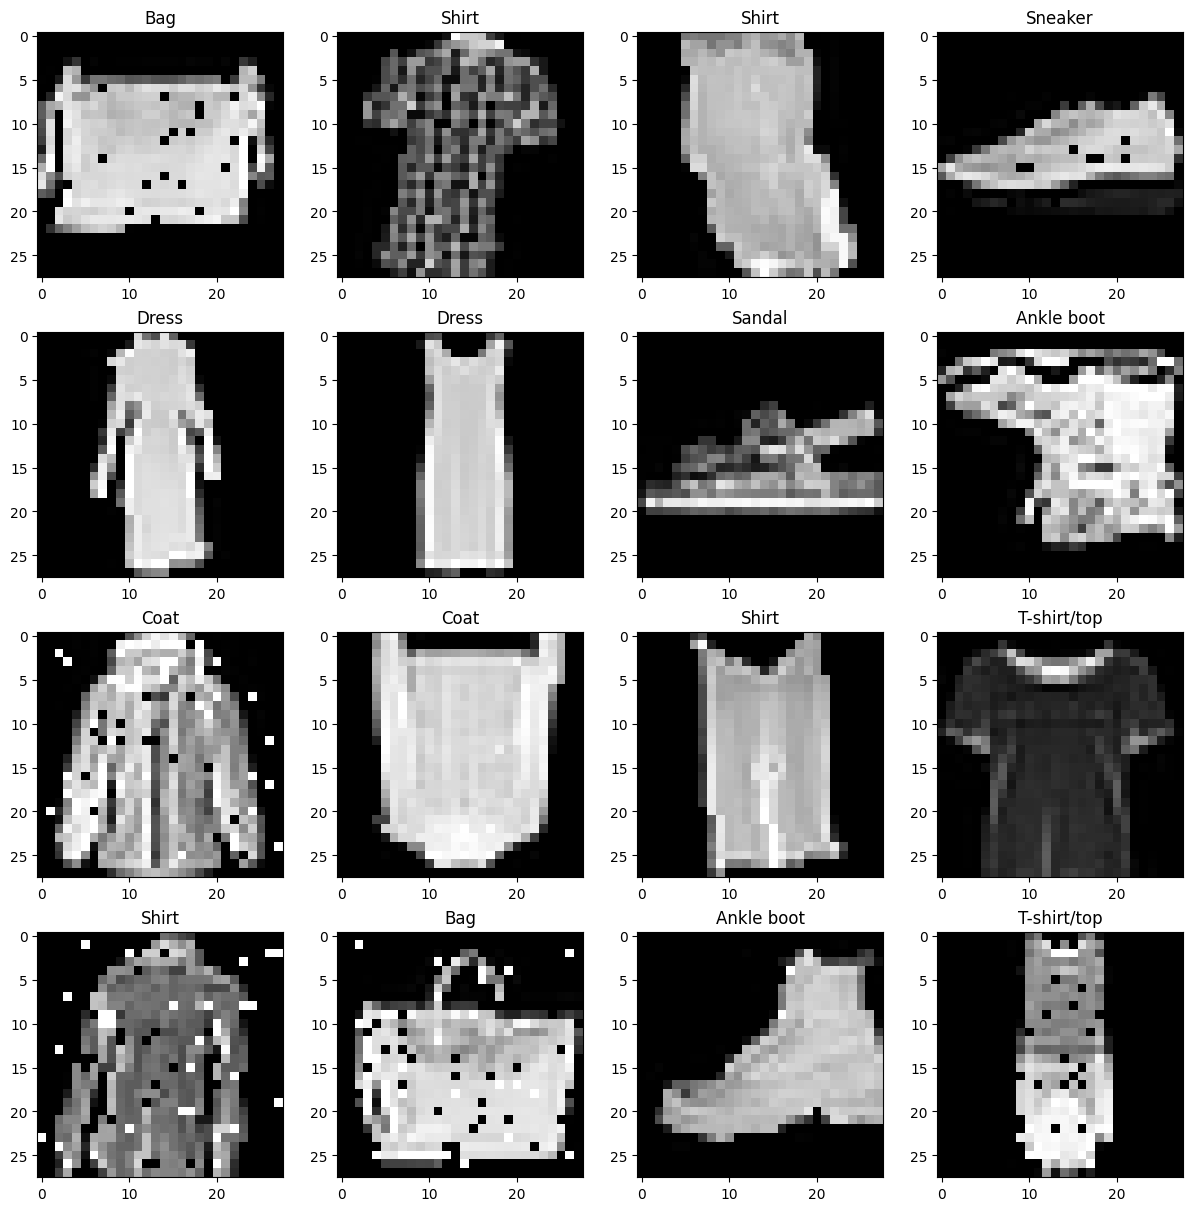

In [11]:
g = torch.Generator(device=device).manual_seed(42)
indices = torch.randint(low=0, high=len(train_data), size=(16,), generator=g, device=device).tolist()

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), constrained_layout=True)

for ax, idx in zip(axes.ravel(), indices):
    img, label = train_data[idx]
    ax.imshow(img.squeeze(0), cmap="gray")
    ax.set_title(train_data.dataset.classes[label])


## 2. TinyVGG for FashionMNIST

**TinyVGG** is a small, VGG-style convolutional neural network:

* Stack of **Conv → ReLU → Conv → ReLU → MaxPool** blocks
* Then **Flatten → Dense (Linear)** for classification
* Much **smaller and cheaper** than full VGG, but keeps the same idea:

  > “Use several small convolutions, then downsample with pooling.”

For 28×28 grayscale FashionMNIST, a simple TinyVGG variant works very well and is easy to train on CPU.

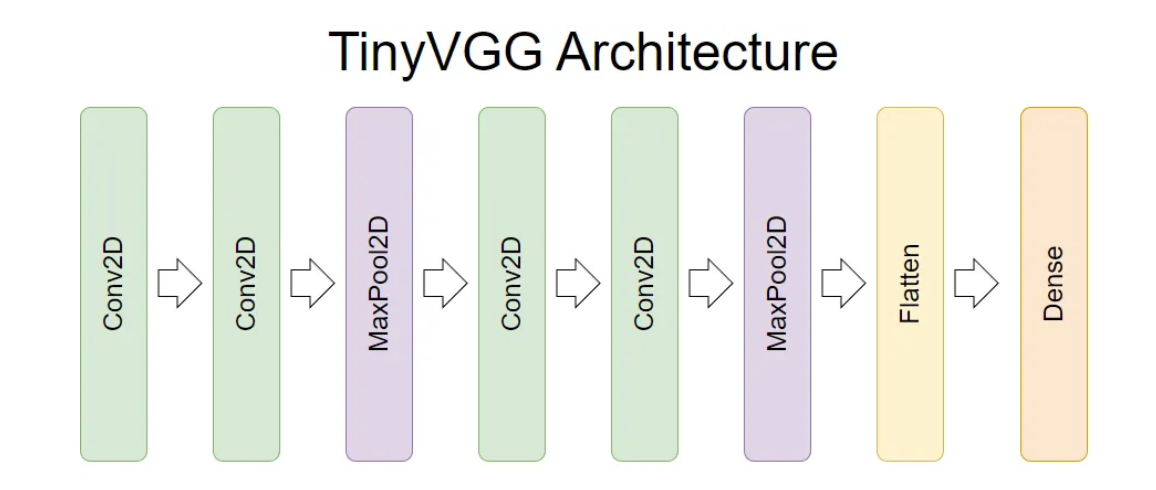

In [12]:
# | Stage         | Output shape (H=32, classes=10) |
# |--------------|----------------------------------|
# | Input        | [B, 1, 28, 28]                   |
# | Conv2D       | [B, 32, 28, 28]                  |
# | Conv2D       | [B, 32, 28, 28]                  |
# | MaxPool2D    | [B, 32, 14, 14]                  |
# | Conv2D       | [B, 32, 14, 14]                  |
# | Conv2D       | [B, 32, 14, 14]                  |
# | MaxPool2D    | [B, 32, 7, 7]                    |
# | Flatten      | [B, 1568]                        |
# | Dense (Head) | [B, 10]                          |


class TinyVGGForFashionMNIST(nn.Module):
    """
    This is TinyVGG-style CNN for 28x28 grayscale images 
    
    Block 1: Conv2D -> ReLU -> Conv2D -> ReLU -> MaxPool
    Block 2: Conv2D -> ReLU -> Conv2D -> ReLU -> MaxPool
    Head   : Flatten -> Linear (to num_classes)
    """
    def __init__(self, in_channels: int = 1, hidden_units: int = 32, num_classes: int = 10, img_size: int = 28):
        super().__init__()
        
        # -- Convolutional feature extractor --
        # Input to the model: x.shape = [B, in_channels=1, 28, 28]
        # Purpose of the layer: To learn low-level features (edges, simple textures), then downsample.
        self.conv_block1 = nn.Sequential(
            # [B, 1, 28, 28] -> [B, H, 28, 28]
            nn.Conv2d(in_channels, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            # [B, H, 28, 28] -> [B, H, 28, 28]
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            # [B, H, 28, 28] -> [B, H, 14, 14]
            nn.MaxPool2d(kernel_size=2)
        )
        
        # -- Block 2 -- 
        # Purpose: To learn higher-level features (parts of clothes, shapes), then downsample again
        self.conv_block2 = nn.Sequential(
            # [B, H, 14, 14] -> [B, H, 14, 14]
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            # [B, H, 14, 14] -> [B, H, 14, 14]
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            # [B, H, 14, 14] -> [B, H, 7, 7]
            nn.MaxPool2d(kernel_size=2)
        )
        
        # -- Compute flattened dimension dynamically --
        # Instead of hard-coding "hidden_utils * 7 * 7", we run a fake image through 
        # the conv block once to see what the final feature-map size is.
        with torch.no_grad():
            x = torch.zeros(1, in_channels, img_size, img_size) # [1, 1, 28, 28]
            x = self.conv_block1(x)                             # [1, H, 14, 14]
            x = self.conv_block2(x)                             # [1, H, 7, 7]
            flatten_dim = x.numel()                             # H * 7 * 7 (e.g., 32 * 7 * 7 = 1568)
        
        # -- Classification head (Dense part) -- 
        self.classsifier = nn.Sequential(
            # [B, H, 7, 7] -> [B, H*7*7]
            nn.Flatten(),
            nn.BatchNorm1d(flatten_dim),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=flatten_dim, out_features=num_classes)
        )
    
    def forward(self, x):
        # x: [B, 1, 28, 28]
        x = self.conv_block1(x) # -> [B, H, 14, 14]
        x = self.conv_block2(x) # -> [B, H, 7, 7]
        x = self.classsifier(x) # -> [B, num_classes]
        return x
            

### 2.1 – Instantiate the model and sanity-check the forward pass

Before training, we pick a device (`cpu`/`cuda`), create a `TinyVGGForFashionMNIST` instance with the right number of classes, and run a dummy batch of images through it.  
This confirms that:

- the model is on the correct device  
- the input shape `[B, 1, 28, 28]` is accepted  
- the output logits have shape `[B, num_classes]` (10 for FashionMNIST)


In [13]:
print(f"Number of classes : {len(train_data.dataset.classes)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TinyVGGForFashionMNIST(hidden_units=64).to(device)

dummy = torch.zeros(4, 1, 28, 28).to(device) # Batch of 4 dummy images
out = model(dummy)
print(f"Output shape: {out.shape}") # [4, num_classes]



Number of classes : 10
Output shape: torch.Size([4, 10])


## 3. Train the TinyVGGForFashionMNIST model

In this section we’ll move from “just defined” to “actually training” the model.

We’ll go through the usual training pipeline:

1. **Choose loss function and optimizer**
   - Use `CrossEntropyLoss` for multi-class classification (10 FashionMNIST classes).
   - Pick an optimizer (we’ll start with `Adam`) and a learning rate.

2. **Write a training step (one epoch over the training set)**
   - Loop over `train_loader`
   - Move batches to `device`
   - Forward pass → compute logits
   - Compute loss and accuracy
   - Backward pass (`loss.backward()`) and optimizer step
   - Track running metrics for the epoch

3. **Write a validation / test step**
   - Disable gradients with `torch.no_grad()` and `model.eval()`
   - Loop over `val_loader` (or `test_loader`)
   - Compute loss and accuracy without updating the model
   - Use this to monitor overfitting vs. generalization

4. **High-level training loop**
   - For each epoch:
     - run **train step**
     - run **validation step**
     - log losses and accuracies
   - Optionally: keep track of the **best model** on the validation set.

5. **Inspect training curves and final metrics**
   - Plot train vs. val loss/accuracy over epochs
   - Look at a few predictions (correct + wrong) to sanity-check behavior

We’ll start with Step 3.1: defining the loss function and optimizer.

### 3.1 – Training and validation loops

Now we define reusable training loops around our `TinyVGGForFashionMNIST` model.

We’ll create three functions:

1. **`train_one_epoch(...)`**  
   - Puts the model in `train()` mode  
   - Loops over `train_loader`  
   - For each batch:  
     - moves data to `device`  
     - does a forward pass to get logits  
     - computes the loss with `CrossEntropyLoss`  
     - runs backprop (`loss.backward()`) and `optimizer.step()`  
   - Accumulates average **training loss** and **accuracy** for the epoch.

2. **`validate_one_epoch(...)`**  
   - Puts the model in `eval()` mode and uses `torch.inference_mode()`  
   - Loops over `val_loader` without computing gradients  
   - Computes average **validation loss** and **accuracy**.  
   - This tells us how well the model generalizes and whether it’s overfitting.

3. **`fit(...)`**  
   - High-level loop over multiple epochs  
   - Calls `train_one_epoch` and `validate_one_epoch` each epoch  
   - Stores metrics in a `history` dictionary (train/val loss & accuracy)  
   - Prints progress every few epochs so we can monitor training.

These functions will form a reusable training template for future experiments.


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from typing import Dict, List, Tuple

# Compute classification accuracy for a batch of logits and integer labels.
# Returns a scalar tensor with value in [0, 1]
def accuracy_from_logits(logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    preds = logits.argmax(dim=1)        # class with highest logit
    correct = (preds == targets).sum()  # number of correct predications
    
    return correct.float()/targets.size(0)

# Run one training epoch.
# - model is put in training mode
# - gradients are computed and optimizer steps are taken
# - returns (epoch_loss, epoch_accuracy_in_percent)
def train_one_epoch(model: nn.Module, optimizer: torch.optim.Optimizer,loss_fn: nn.Module,
                    train_loader: DataLoader, device: torch.device,
                    l1_reg_coeff: float = 0.0, l2_reg_coeff: float = 0.0) -> Tuple[float, float]:
    model.train()
    
    running_loss = 0.0
    running_acc = 0.0
    total_samples_consumed = 0
    
    for X, y in train_loader:
        # Move the batch to device
        X = X.to(device)
        y = y.to(device)
        
        # 1. Forward pass 
        optimizer.zero_grad(set_to_none=True)
        logits = model(X)
        loss = loss_fn(logits, y)
        
        if l1_reg_coeff > 0.0 or l2_reg_coeff > 0.0:
            l1_penalty = 0.0
            l2_penalty = 0.0 
            for param in model.parameters():
                if l1_reg_coeff > 0.0:
                    l1_penalty += torch.norm(param, 1)
                if l2_reg_coeff > 0.0:
                    l2_penalty += torch.norm(param, 2)

            loss += ((l1_reg_coeff * l1_penalty) +
                     (l2_reg_coeff * l2_penalty))
        
        # 2. Backward pass + optimizer step
        loss.backward()
        optimizer.step()
        
        # 3. Update running metrics (no need to track gradients here)
        with torch.no_grad():
            batch_acc = accuracy_from_logits(logits, y) # in [0, 1]
            batch_size = y.size(0)
            
            running_loss += loss.item() * batch_size
            running_acc += batch_acc.item() * batch_size
            total_samples_consumed += batch_size
            
    epoch_loss = running_loss/total_samples_consumed
    epoch_acc = 100.0 * running_acc/total_samples_consumed     # convert to %
    
    return epoch_loss, epoch_acc

# Run one validation epoch
# - model is put into eval mode
# - gradients are disabled
# - returns (epoch_loss, ecpoch_accuracy_in_percent)
def validate_one_epoch(model: nn.Module, loss_fn: nn.Module, val_loader: DataLoader,
                       device: torch.device) -> Tuple[float, float]:
    model.eval()
    
    running_loss = 0.0
    running_acc = 0.0
    total_samples_consumed = 0
    
    with torch.inference_mode():
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            
            logits = model(X)
            loss = loss_fn(logits, y)
            
            batch_acc = accuracy_from_logits(logits, y)
            batch_size = y.size(0)
            
            running_loss += loss.item() * batch_size
            running_acc += batch_acc.item() * batch_size
            total_samples_consumed += batch_size

    epoch_loss = running_loss/total_samples_consumed
    epoch_acc = 100.0 * running_acc/total_samples_consumed
    
    return epoch_loss, epoch_acc


# High-level training loop.
# For each epoch:
#     - run one training epoch
#     - run one validation epoch
#     - store metrics in 'history' dict
# Returns:
#     history = {
#         "train_loss": [...],
#         "train_acc":  [...],
#         "val_loss":   [...],
#         "val_acc":    [...],
#     }
def fit(model: nn.Module, optimizer: torch.optim.Optimizer, loss_fn: nn.Module,
        train_dataloader: DataLoader, val_dataloader: DataLoader = None,
        device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        epochs: int = 50, verbose_every: int | None = 5):
    
    history = { "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [] }
    
    for ep in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, optimizer, loss_fn, train_dataloader, device)
        if val_dataloader is not None:
            val_loss, val_acc = validate_one_epoch(model, loss_fn, val_dataloader, device)
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        if val_dataloader is not None:
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
        
        if verbose_every is not None and verbose_every > 0:
            should_print = (ep % verbose_every == 0 or ep == 1 or ep == epochs)
        else:
            should_print = False
        
        if val_dataloader is not None:
            if should_print:
                print(f"Epoch {ep:3d} | Training loss: {train_loss:.4f}, Training accuracy: {train_acc:6.2f}% | "
                      f"Validation loss: {val_loss:.4f}, Validation acccuracy: {val_acc:6.2f}%")
        else:
            if should_print:
                print(f"Epoch {ep:3d} | "
                      f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:6.2f}%")

    return history

### 3.2 – Check parameter distribution across layers

We inspect the distribution of learned parameters (weights and biases) in our
TinyVGG model after training. This can help diagnose underfitting/overfitting
and how strongly different layers are being used.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np


NR_EPOCHS=20

def plot_param_distribution(learning_rates=None, loss_fn=nn.CrossEntropyLoss,
                            optimizer_cls=optim.Adam, **optimizer_kwargs):
    
    if learning_rates is not None:
        # turn generator into list so we can reuse and get its length
        param_list = list(model.named_parameters())
        n_params = len(param_list)
        n_lrs = len(learning_rates)

        # one row per param, one column per learning rate
        fig, axes = plt.subplots(
            n_params, n_lrs,
            figsize=(4*n_lrs, 3*n_params),
            sharex=False, 
            sharey=False
        )

        # make sure that the axes is 2D even if n_params or n_lrs == 1
        axes = np.atleast_2d(axes)

        for j, lr in enumerate(learning_rates):
            print(f"\n=== Training with lr = {lr} ({j+1}/{len(learning_rates)}) ===")
        
            # reset model parameters
            model.load_state_dict(initial_state)
            
            # create a fresh optimizer for this lr 
            optimizer = optimizer_cls(model.parameters(), lr=lr, **optimizer_kwargs)
            # optional: clear any leftover grads
            optimizer.zero_grad(set_to_none=True)

            _ = fit(model=model, optimizer=optimizer, loss_fn=loss_fn,
                train_dataloader=train_loader, val_dataloader=val_loader, device=device,
                epochs=15, verbose_every=5)

            for i, (name, p) in enumerate(param_list):
                # get parameter values in 1D array
                w = p.detach().cpu().numpy().ravel()
                
                # line-style histogram (no bars)
                counts, edges = np.histogram(w, bins='auto', density=True)
                centers = (edges[:-1] + edges[1:])/2
                
                ax = axes[i, j]
                ax.plot(centers, counts)
                
                # set axis on every subplot
                ax.set_xlabel("Parameter Value")
                ax.set_ylabel("Count")
                        
                if j == 0:
                    ax.set_ylabel(name)         # row labels: parameter names
                if i == 0:
                    ax.set_title(f"lr = {lr}")  # column titles: learning rates
                
        plt.tight_layout()
        plt.show()

In [16]:
# lrs = [0.01, 0.001, 0.0001, 0.00001]
lrs = None # Does nothing 

plot_param_distribution(
    learning_rates=lrs,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer_cls=optim.Adam,
    weight_decay=1e-4    # goes into **optimizer_kwargs
)

### 3.3 – Loss function and optimizer

For multi-class classification we use `CrossEntropyLoss`, which combines
`LogSoftmax + NLLLoss` in one function and expects raw logits from the model.
We optimize the model parameters with Adam.


In [17]:
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.01)

print(f"Loss function: {loss_fn}")
print(f"Optimizer :\n{optimizer}")

print(f"type Loss function: {type(loss_fn)}")
print(f"type Optimizer : {type(optimizer)}")

Loss function: CrossEntropyLoss()
Optimizer :
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
type Loss function: <class 'torch.nn.modules.loss.CrossEntropyLoss'>
type Optimizer : <class 'torch.optim.adam.Adam'>


### 3.4 – Train TinyVGG and record metrics [Baseline training with fixed LR]

Now that we have:

- a model (`TinyVGGForFashionMNIST`)
- a loss function (`CrossEntropyLoss`)
- an optimizer (`Adam`)
- and reusable epoch helpers (`train_one_epoch`, `validate_one_epoch`)

we can call `fit(...)` to actually **train** the network:

- loop over the training and validation loaders for a chosen number of epochs  
- update model weights on the training set  
- evaluate on the validation set after each epoch  
- store `train_loss`, `train_acc`, `val_loss`, and `val_acc` in a `history` dict for later plotting.


In [18]:
import copy

initial_state = copy.deepcopy(model.state_dict())

# history = fit(model=model, optimizer=optimizer, loss_fn=loss_fn, train_dataloader=train_loader,
#               val_dataloader=val_loader, device=device, epochs=30, verbose_every=1)

### 3.5 – Train TinyVGG with learning rate scheduling

Now that we’ve trained TinyVGG with a **fixed learning rate** and seen that the validation loss starts to plateau after a certain number of epochs, we can use this information to add a **learning rate scheduler**.

We’ll:

- keep the same model architecture and loss function  
- re-initialize the model/optimizer (so we start from the same point as the baseline)  
- use a `ReduceLROnPlateau` scheduler to **halve** the learning rate when the validation loss stops improving  
- train again and compare the metrics with the fixed-LR baseline 

#### 3.5.1 – Update `fit(...)` to optionally use a scheduler

In this section, we’ll slightly modify our existing `fit(...)` function so it can **optionally take a learning rate scheduler**. If a scheduler is provided, `fit(...)` will call it after each epoch using the validation loss, letting us reuse the same training loop for both fixed and scheduled learning rates.


In [19]:
def fit(model: nn.Module, optimizer: torch.optim.Optimizer, loss_fn: nn.Module,
        train_dataloader: DataLoader, val_dataloader: DataLoader = None,
        device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        epochs: int = 50, verbose_every: int | None = 5, scheduler: optim.lr_scheduler = None):
    
    history = { "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "curr_lr": []}
    curr_lr=1e-8 # just some dummy value
    
    for ep in range(1, epochs + 1):
        
        train_loss, train_acc = train_one_epoch(model, optimizer, loss_fn, train_dataloader,
                                                device, l1_reg_coeff=0.0001, l2_reg_coeff=0.0001)
        
        if val_dataloader is not None:
            val_loss, val_acc = validate_one_epoch(model, loss_fn, val_dataloader, device)
        
        if val_dataloader is not None and scheduler is not None:
                scheduler.step(val_loss)
                curr_lr = optimizer.param_groups[0]["lr"]
                history["curr_lr"].append(curr_lr)
        
        # Record metrics and current LR
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        if val_dataloader is not None:
            history["val_loss"].append(val_loss)
            history["val_acc"].append(val_acc)
                    
        if verbose_every is not None and verbose_every > 0:
            should_print = (ep % verbose_every == 0 or ep == 1 or ep == epochs)
        else:
            should_print = False
        
        if val_dataloader is not None:
            if should_print:
                print(f"Epoch {ep:3d}| Training loss: {train_loss:.4f}, Training accuracy: {train_acc:3.2f}%| "
                      f"Validation loss: {val_loss:.4f}, Validation acccuracy: {val_acc:3.2f}%| "
                      f"LR: {curr_lr:.5e}")
        else:
            if should_print:
                print(f"Epoch {ep:3d}| "
                      f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:4.2f}%")

    return history

#### 3.5.2 – Define the scheduler and train

Using what we learned from the baseline curve (validation loss flattening after ~N epochs), we can choose a small `patience` and a decay `factor`.

In [20]:
from torch import optim
import copy

# Reset model to the same initial weights as the baseline run
model.load_state_dict(initial_state)

# recreate the optimizer so it's internal state (e.g., Adam moments) is also fresh
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

schedular = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    factor=0.75,        # halve the LR when triggered
    patience=3,        # wait 2 epochs  with no sufficient improvemnt
    threshold=0.05,    # "improvement" means val_loss drops by at least 0.01
    min_lr=1e-7,       # don't go below this LR
    threshold_mode='abs'
)

history_sched = fit(model=model, optimizer=optimizer, loss_fn=loss_fn, train_dataloader=train_loader,
              val_dataloader=val_loader, device=device, epochs=30, verbose_every=1, scheduler=schedular)


Epoch   1| Training loss: 1.6819, Training accuracy: 62.17%| Validation loss: 0.5918, Validation acccuracy: 79.60%| LR: 1.00000e-04
Epoch   2| Training loss: 1.3785, Training accuracy: 72.55%| Validation loss: 0.5093, Validation acccuracy: 82.89%| LR: 1.00000e-04
Epoch   3| Training loss: 1.2783, Training accuracy: 75.97%| Validation loss: 0.4042, Validation acccuracy: 85.86%| LR: 1.00000e-04
Epoch   4| Training loss: 1.2226, Training accuracy: 77.52%| Validation loss: 0.4491, Validation acccuracy: 85.06%| LR: 1.00000e-04
Epoch   5| Training loss: 1.2003, Training accuracy: 78.08%| Validation loss: 0.3868, Validation acccuracy: 86.96%| LR: 1.00000e-04
Epoch   6| Training loss: 1.1510, Training accuracy: 79.70%| Validation loss: 0.3346, Validation acccuracy: 88.06%| LR: 1.00000e-04
Epoch   7| Training loss: 1.1497, Training accuracy: 79.40%| Validation loss: 0.3568, Validation acccuracy: 87.89%| LR: 1.00000e-04
Epoch   8| Training loss: 1.1314, Training accuracy: 79.76%| Validation loss

### 3.6 – Visualize training curves

Now that we’ve run `fit(...)` and collected metrics in `history`, we want to **see** how training behaved over time.

We’ll:

- Plot **training vs. validation loss** across epochs  
  - check that both are decreasing  
  - watch for divergence (sign of overfitting)

- Plot **training vs. validation accuracy** across epochs  
  - confirm that the model is actually learning  
  - see where performance starts to saturate (good stopping point)

These two plots give a quick, visual summary of:
- how fast the model learns,
- whether more epochs might help,
- and whether regularization / architecture changes are needed.


In [21]:
def plot_history(history, every=1):
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), constrained_layout=True)

    # --- Training and validation loss ---
    ax = axes[0]
    ax.plot(epochs[::every], history["train_loss"][::every], label="Training loss")
    ax.plot(epochs[::every], history["val_loss"][::every],  label="Validation loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs Epoch")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

    # --- Training and validation accuracy ---
    ax = axes[1]
    ax.plot(epochs[::every], history["train_acc"][::every], label="Training accuracy")
    ax.plot(epochs[::every], history["val_acc"][::every],  label="Validation accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")  # since you're storing *percent*
    ax.set_title("Accuracy vs Epoch")
    ax.grid(True, linestyle="--", alpha=0.4)
    ax.legend()

    plt.show()


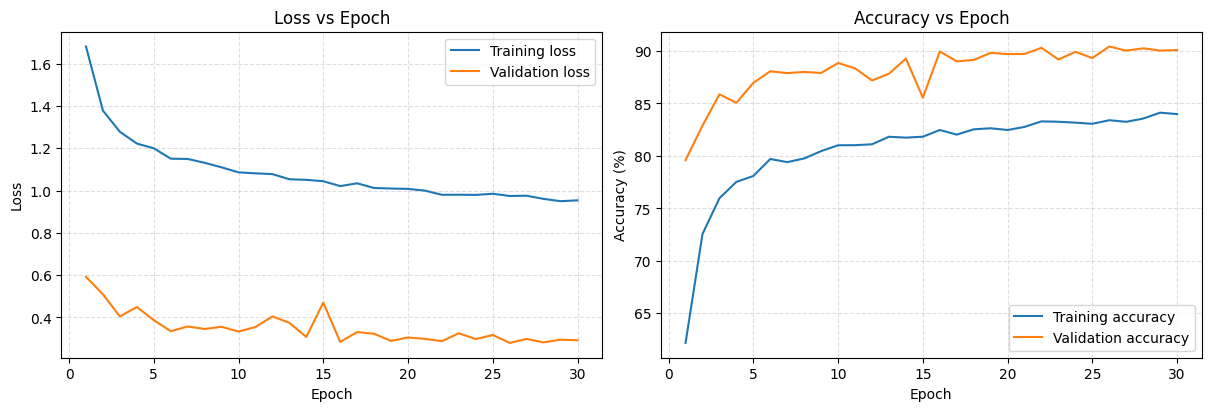

In [22]:
plot_history(history_sched)

### 3.6 – Final evaluation on the test set

Now that training looks stable, we evaluate the final TinyVGG model on the
held-out test set.  

We reuse the same `loss_fn` and the validation loop (no gradient tracking) and
report:

- test loss (CrossEntropy)
- test accuracy (% correct predictions on unseen data)


In [23]:
test_loss, test_acc = validate_one_epoch(model=model, loss_fn=loss_fn, val_loader=test_loader, device=device)

print(f"Test loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Test loss: 0.3055
Test Accuracy: 89.65%


## 4. Inspect predictions

The overall test accuracy tells us *how often* TinyVGG is correct, but not **where** it is making mistakes.  
In this section we’ll dig into the model’s predictions more closely:

- summarize per–class performance with a **classification report** (precision, recall, F1, support)
- build a **confusion matrix** to see which classes are most often confused
- look at a few **correctly** and **incorrectly** classified test images
- identify patterns in the errors (e.g. shirts vs T-shirts, coats vs pullovers)

This kind of error analysis is what you’d normally do in a real project before deciding
whether to collect more data, tweak the architecture, or deploy the model.

### 4.1 Collect all predictions on the test set

First we need to **collect all predictions on the test set**.

We’ll:

- run the trained model over the entire `test_loader` (in `eval` / inference mode),
- store all output logits and the corresponding true labels,
- convert logits to predicted class indices (`argmax`).

These tensors (`all_logits`, `all_labels`, `preds`) will then be reused to compute the **classification report** and later the **confusion matrix** and example visualizations.


In [24]:
all_images = []
all_labels = []
all_logits = []

model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)
        
        logits = model(X)
        
        all_logits.append(logits.cpu())
        all_images.append(X.cpu())
        all_labels.append(y.cpu())


all_images = torch.cat(all_images)  # inputs
all_labels = torch.cat(all_labels)
all_logits = torch.cat(all_logits)  # output

preds = all_logits.argmax(dim=1)


### 4.2 – Classification report (per-class metrics)

Overall accuracy is helpful, but it hides *which* classes the model is good or bad at.
To dig deeper, we compute a **classification report** on the test set using
`sklearn.metrics.classification_report`.

For each FashionMNIST class, this gives us:

- **precision** – of all predictions *for this class*, how many were correct?
- **recall** – of all true samples *of this class*, how many did we find?
- **f1-score** – harmonic mean of precision and recall (balances both)
- **support** – number of test samples for that class

These per-class metrics help us spot classes that are under-performing and may
need more data, better augmentation, or architecture changes.
```


In [25]:
from sklearn.metrics import classification_report

print(f"Classification report:\n")
print(classification_report(all_labels, preds, target_names=train_data.classes))

Classification report:



AttributeError: 'Subset' object has no attribute 'classes'

### 4.3 – Confusion matrix

Per-class metrics tell us *how* each class performs, but not *who gets confused with whom*.  
A confusion matrix shows, for every true class, how the predictions are distributed:

- rows = true labels  
- columns = predicted labels  
- diagonal = correct predictions  
- off-diagonal = confusions (e.g. `T-shirt/top → Shirt`)

We’ll plot a normalized confusion matrix on the test set using `sklearn.metrics.confusion_matrix`.


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, preds)
cm_norm = cm.astype(np.float32)/cm.sum(axis=1, keepdims=True) * 100 # to get %

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm_norm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

thresh = cm_norm.max() / 2.0
for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
    ax.text(j, i, f"{cm_norm[i, j]:.1f}", ha="center", va="center", 
            color="white" if cm_norm[i, j] > thresh else "black", fontsize=9)
    
ax.set_xticks(np.arange(len(train_data.classes)))
ax.set_xticklabels(train_data.classes, rotation=45, ha="right")

ax.set_yticks(np.arange(len(train_data.classes)))
ax.set_yticklabels(train_data.classes)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Normalized confusion matrix (test set) - All values in %")

plt.tight_layout()
plt.show()

### 4.4 – Example predictions

Finally, we’ll visualize a few individual test images together with:

- the **true** class
- the model’s **predicted** class
- whether the prediction is correct or not

Looking at concrete successes and failures often reveals patterns
(e.g. dark images, cropped items, visually similar classes such as
`T-shirt/top` vs `Shirt`).


In [ ]:
def show_examples(images, labels, preds, classes, n=8, title="Examples"):
    plt.figure(figsize=(12, 12))
    idxs = torch.randperm(len(images))[:n]
    for i, idx in enumerate(idxs, start=1):
        img = images[idx].squeeze().cpu().numpy()
        true_lbl = classes[labels[idx].item()]
        pred_lbl = classes[preds[idx].item()]

        plt.subplot(n//4, 4, i)
        plt.imshow(img, cmap="gray")
        plt.title(f"T: {true_lbl}\nP: {pred_lbl}")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage after you’ve built `all_logits`, `all_labels`, `preds`:
correct_mask = preds == all_labels
incorrect_mask = preds != all_labels

show_examples(images=all_images[correct_mask], labels=all_labels[correct_mask],
              preds=preds[correct_mask], classes=test_data.classes, n=16, title="Random correct examples")

show_examples(images=all_images[incorrect_mask], labels=all_labels[incorrect_mask],
              preds=preds[incorrect_mask], classes=test_data.classes, n=16, title="Random incorrect examples")
              
        


## 5. Summary and next steps

- We built a TinyVGG-style CNN and trained it on FashionMNIST.
- Final test accuracy: ~90% with balanced per-class precision/recall.
- Confusion matrix and example predictions show most errors happen between
  visually similar classes (e.g. T-shirt vs Shirt, Pullover vs Coat).

Possible next steps:

- add data augmentation,
- try a deeper / wider model,
- or fine-tune a pretrained CNN for comparison.
